In [1]:
from copy import copy
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

In [16]:
N = 30
q = 1
T = 5000

alphas = [80/np.sqrt(np.sum([((4*np.pi**2)**k)*((j/2)**(2*k)) for k in range(3)])) for j in range(2*N + 1)]
alphas_4 = [4*alphas[j] for j in range(len(alphas))]
D_2m = sum(alphas_4)

b = 80
C = 1
D = C*np.sqrt(b)
L = C*b
G = C*np.sqrt(b**3)

M = int(np.ceil(0.5*np.log2((G**2*T)/(8*L**2*D**2))) + 1)
eta = np.array([min(1/(8*L), np.sqrt(D**2/(8*G**2*T)*2**i)) for i in range(1, M+1)])

np.random.seed(0)

In [17]:
def join_arrs(a0, arr1, arr2):
    new_arr = np.zeros(len(arr1) + len(arr2))
    new_arr[::2] = arr1
    new_arr[1::2] = arr2
    new_arr = np.concatenate(([a0], new_arr))
    return new_arr

def solve_euler(h, q):
    t = symbols('t')
    x = Function('x')
    C1 = symbols('C1')
    C2 = symbols('C2')
    x = dsolve(- diff(x(t), t, t) + q**2*x(t) - h , x(t)).rhs
    cond1 = x.subs(t, 0) - x.subs(t, 1)
    cond2 = diff(x, t).subs(t, 0) - diff(x, t).subs(t, 1)
    solution = solve([cond1, cond2], [C1, C2])
    x = x.subs(C1, solution[C1]).subs(C2, solution[C2])
    return x

def pop_fourier_coefs(func):
    a0 =  np.trapezoid(func(np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
    an = np.zeros(N)
    bn = np.zeros(N)

    for n in range(1, N+1):
        an[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.cos(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
        bn[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.sin(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))

    return a0, an, bn

def fourier_series(t, a0, an, bn, N):
    return a0 + np.sum([an[n] * np.sqrt(2)*np.cos((n+1) * 2*np.pi * t) + bn[n] * np.sqrt(2)*np.sin((n+1) * 2*np.pi * t) for n in range(N)])


## $\psi$ = 1.5

In [18]:
# Initialize arrays
w = np.zeros((T, 2*N+1))
w_experts = np.zeros((T, M, 2*N+1))
w_experts_wave = np.zeros((T, M, 2*N+1))

# Initialize expert weights
w_experts_init = np.random.random((M, 2*N+1))
w_experts[0] = w_experts_init
w_experts_wave[0] = w_experts_init.copy()

# Initialize probabilities and tracking variables
p = np.zeros((T, M))
p[0] = np.ones(M) / M
m = np.zeros((T, M))
loss = np.zeros((T, M))
grads = np.zeros((T, 2*N+1))

# System setup
psi = 1.5
t = symbols('t')
h = lambdify(t, 10*pi**2*cos(2*psi*pi*t))
x = lambdify(t, solve_euler(h_sp, q))

# Precompute Fourier coefficients
a0, an, bn = pop_fourier_coefs(x())
h_a0, h_an, h_bn = pop_fourier_coefs(h)
x_hat = join_arrs(a0, an, bn)
h_hat = join_arrs(h_a0, h_an, h_bn)

# Precompute common terms
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2
freq_terms = (2*np.pi)**2 * ceil_j_sq
sqrt_alphas = np.sqrt(alphas)

# Tracking variables
lam = 1  # Regularization parameter
V = 0  # Gradient variation
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences

# Vectorized functions
def gradient(w):
    return alphas*(q**2 + freq_terms)*w - sqrt_alphas*h_hat

def J_n(w):
    term1 = 0.5*np.sum(alphas*(q**2 + freq_terms)*w**2)
    term2 = np.sum(sqrt_alphas*h_hat*w)
    return term1 - term2

# Main optimization loop
for i in range(T-1):
    # Update combined weights
    w[i] = np.einsum('i,ij->j', p[i], w_experts[i])

    # Compute gradient
    gradient_w = gradient(w[i])
    grads[i+1] = gradient_w

    # Update V and epsilon
    grad_diff = grads[i+1] - grads[i]
    V += np.sum(grad_diff**2)
    eps = min(1/(8*D**2*L), np.sqrt(np.log(M)/(D**2*V)))

    # Update experts
    grad_term = eta[:, None] * gradient_w
    w_experts_wave[i+1] = w_experts_wave[i] - grad_term
    w_experts[i+1] = w_experts_wave[i+1] - grad_term

    # Compute losses
    if i == 0:
        loss[i] = np.dot(w_experts[i], gradient_w)
    else:
        expert_diffs = w_experts[i] - w_experts[i-1]
        loss[i] = np.dot(w_experts[i], gradient_w) + lam*np.sum(expert_diffs**2, axis=1)

    # Compute m[i+1]
    next_diffs = w_experts[i+1] - w_experts[i]
    m[i+1] = np.dot(w_experts[i+1], gradient_w) + lam*np.sum(next_diffs**2, axis=1)

    # Update probabilities
    cum_loss = np.sum(loss[:i+1], axis=0) if i > 0 else loss[0]
    p[i+1] = np.exp(-eps*(cum_loss + m[i+1]))
    p[i+1] /= p[i+1].sum()

    # Track performance
    current_diff = J_n(w[i]) - J_n(x_hat/sqrt_alphas)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(sum(Dif_J_n)/n)

In [19]:
print(np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas))))

7.578343544878408e-05


In [20]:
Regret_J_n[-1]

np.float64(2.9039350829870805)

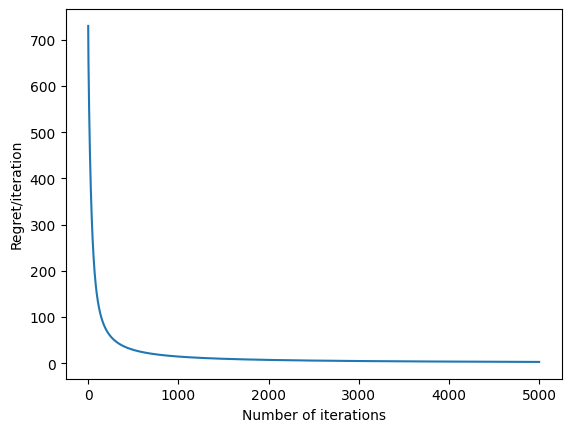

In [21]:
plt.plot(Regret_J_n)
plt.xlabel('Number of iterations')
plt.ylabel('Regret/iteration')
plt.show()

## $\psi$ = N(0, 0.03)

In [22]:
# Precompute constants
t = symbols('t')
psi = np.random.normal(0, 0.03, T)  # Random psi values for each timestep
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2  # Precomputed ceiling terms

# Initialize arrays
w = np.zeros((T, 2*N+1))  # Main weight vector
w_experts = np.random.random((T, M, 2*N+1))  # Expert weights
w_experts_wave = w_experts.copy()  # Auxiliary expert weights

p = np.zeros((T, M))  # Expert probabilities
p[0] = np.ones(M) / M  # Uniform initial probabilities

m = np.zeros((T, M))  # Auxiliary tracking variable
loss = np.zeros((T, M))  # Loss tracking
grads = np.zeros((T, 2*N+1))  # Gradient history

# Tracking variables
lam = 1  # Regularization parameter
V = 0  # Gradient variation
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences

# Vectorized functions
def compute_gradient(w, h_hat):
    """Compute gradient of objective function"""
    terms = alphas * (q**2 + (2*np.pi)**2 * ceil_j_sq)
    return terms * w - np.sqrt(alphas) * h_hat

def compute_J_n(w, h_hat):
    """Compute objective function value"""
    terms = alphas * (q**2 + (2*np.pi)**2 * ceil_j_sq)
    return 0.5 * np.sum(terms * w**2) - np.sum(np.sqrt(alphas) * h_hat * w)

# Main optimization loop
for i in range(T-1):
    # Symbolic computations for current psi
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Update main weights
    w[i] = np.einsum('i,ij->j', p[i], w_experts[i])

    # Compute and store gradient
    gradient_w = compute_gradient(w[i], h_hat)
    grads[i+1] = gradient_w

    # Update gradient variation V
    grad_diff = grads[i+1] - grads[i]
    V += np.sum(grad_diff**2)
    eps = min(1/(8*D**2*L), np.sqrt(np.log(M)/(D**2*V)))

    # Update expert weights
    gradient_term = eta[:, np.newaxis] * gradient_w
    w_experts_wave[i+1] = w_experts_wave[i] - gradient_term
    w_experts[i+1] = w_experts_wave[i+1] - gradient_term

    # Compute losses
    if i == 0:
        loss[i] = np.dot(w_experts[i], gradient_w)
    else:
        expert_diffs = w_experts[i] - w_experts[i-1]
        loss[i] = np.dot(w_experts[i], gradient_w) + lam * np.sum(expert_diffs**2, axis=1)

    # Compute m[i+1] for next step
    next_expert_diffs = w_experts[i+1] - w_experts[i]
    m[i+1] = np.dot(w_experts[i+1], gradient_w) + lam * np.sum(next_expert_diffs**2, axis=1)

    # Update expert probabilities
    cumulative_loss = np.sum(loss[:i+1], axis=0) if i > 0 else loss[0]
    p[i+1] = np.exp(-eps * (cumulative_loss + m[i+1]))
    p[i+1] /= p[i+1].sum()  # Normalize

    # Update performance metrics
    current_diff = compute_J_n(w[i], h_hat) - compute_J_n(x_hat/np.sqrt(alphas), h_hat)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [23]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(0.005867164551091264)

In [24]:
Regret_J_n[-1]

np.float64(18.243509755054518)

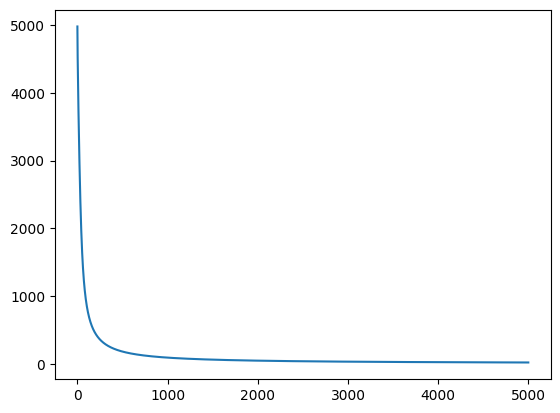

In [25]:
plt.plot(Regret_J_n)

## $\psi$ = [2, 3]

In [ ]:
# Precompute constants
t = symbols('t')
psi = np.linspace(2, 3, T)  #  psi values for each timestep
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2  # Precomputed ceiling terms

# Initialize arrays
w = np.zeros((T, 2*N+1))  # Main weight vector
w_experts = np.random.random((T, M, 2*N+1))  # Expert weights
w_experts_wave = w_experts.copy()  # Auxiliary expert weights

p = np.zeros((T, M))  # Expert probabilities
p[0] = np.ones(M) / M  # Uniform initial probabilities

m = np.zeros((T, M))  # Auxiliary tracking variable
loss = np.zeros((T, M))  # Loss tracking
grads = np.zeros((T, 2*N+1))  # Gradient history

# Tracking variables
lam = 1  # Regularization parameter
V = 0  # Gradient variation
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences

# Vectorized functions
def compute_gradient(w, h_hat):
    """Compute gradient of objective function"""
    terms = alphas * (q**2 + (2*np.pi)**2 * ceil_j_sq)
    return terms * w - np.sqrt(alphas) * h_hat

def compute_J_n(w, h_hat):
    """Compute objective function value"""
    terms = alphas * (q**2 + (2*np.pi)**2 * ceil_j_sq)
    return 0.5 * np.sum(terms * w**2) - np.sum(np.sqrt(alphas) * h_hat * w)

# Main optimization loop
for i in range(T-1):
    # Symbolic computations for current psi
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Update main weights
    w[i] = np.einsum('i,ij->j', p[i], w_experts[i])

    # Compute and store gradient
    gradient_w = compute_gradient(w[i], h_hat)
    grads[i+1] = gradient_w

    # Update gradient variation V
    grad_diff = grads[i+1] - grads[i]
    V += np.sum(grad_diff**2)
    eps = min(1/(8*D**2*L), np.sqrt(np.log(M)/(D**2*V)))

    # Update expert weights
    gradient_term = eta[:, np.newaxis] * gradient_w
    w_experts_wave[i+1] = w_experts_wave[i] - gradient_term
    w_experts[i+1] = w_experts_wave[i+1] - gradient_term

    # Compute losses
    if i == 0:
        loss[i] = np.dot(w_experts[i], gradient_w)
    else:
        expert_diffs = w_experts[i] - w_experts[i-1]
        loss[i] = np.dot(w_experts[i], gradient_w) + lam * np.sum(expert_diffs**2, axis=1)

    # Compute m[i+1] for next step
    next_expert_diffs = w_experts[i+1] - w_experts[i]
    m[i+1] = np.dot(w_experts[i+1], gradient_w) + lam * np.sum(next_expert_diffs**2, axis=1)

    # Update expert probabilities
    cumulative_loss = np.sum(loss[:i+1], axis=0) if i > 0 else loss[0]
    p[i+1] = np.exp(-eps * (cumulative_loss + m[i+1]))
    p[i+1] /= p[i+1].sum()  # Normalize

    # Update performance metrics
    current_diff = compute_J_n(w[i], h_hat) - compute_J_n(x_hat/np.sqrt(alphas), h_hat)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

In [ ]:
Regret_J_n_sqrt[-1]

In [ ]:
Regret_J_n[-1]

In [ ]:
plt.plot(Regret_J_n_sqrt)

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = [0.5]*(T/2) + [1.5]*(T/2)

In [ ]:
# Precompute constants
t = symbols('t')
psi =  [0.5]*int(T/2) + [1.5]*int(T/2)  # psi values for each timestep
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2  # Precomputed ceiling terms

# Initialize arrays
w = np.zeros((T, 2*N+1))  # Main weight vector
w_experts = np.random.random((T, M, 2*N+1))  # Expert weights
w_experts_wave = w_experts.copy()  # Auxiliary expert weights

p = np.zeros((T, M))  # Expert probabilities
p[0] = np.ones(M) / M  # Uniform initial probabilities

m = np.zeros((T, M))  # Auxiliary tracking variable
loss = np.zeros((T, M))  # Loss tracking
grads = np.zeros((T, 2*N+1))  # Gradient history

# Tracking variables
lam = 1  # Regularization parameter
V = 0  # Gradient variation
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences

# Vectorized functions
def compute_gradient(w, h_hat):
    """Compute gradient of objective function"""
    terms = alphas * (q**2 + (2*np.pi)**2 * ceil_j_sq)
    return terms * w - np.sqrt(alphas) * h_hat

def compute_J_n(w, h_hat):
    """Compute objective function value"""
    terms = alphas * (q**2 + (2*np.pi)**2 * ceil_j_sq)
    return 0.5 * np.sum(terms * w**2) - np.sum(np.sqrt(alphas) * h_hat * w)

# Main optimization loop
for i in range(T-1):
    # Symbolic computations for current psi
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Update main weights
    w[i] = np.einsum('i,ij->j', p[i], w_experts[i])

    # Compute and store gradient
    gradient_w = compute_gradient(w[i], h_hat)
    grads[i+1] = gradient_w

    # Update gradient variation V
    grad_diff = grads[i+1] - grads[i]
    V += np.sum(grad_diff**2)
    eps = min(1/(8*D**2*L), np.sqrt(np.log(M)/(D**2*V)))

    # Update expert weights
    gradient_term = eta[:, np.newaxis] * gradient_w
    w_experts_wave[i+1] = w_experts_wave[i] - gradient_term
    w_experts[i+1] = w_experts_wave[i+1] - gradient_term

    # Compute losses
    if i == 0:
        loss[i] = np.dot(w_experts[i], gradient_w)
    else:
        expert_diffs = w_experts[i] - w_experts[i-1]
        loss[i] = np.dot(w_experts[i], gradient_w) + lam * np.sum(expert_diffs**2, axis=1)

    # Compute m[i+1] for next step
    next_expert_diffs = w_experts[i+1] - w_experts[i]
    m[i+1] = np.dot(w_experts[i+1], gradient_w) + lam * np.sum(next_expert_diffs**2, axis=1)

    # Update expert probabilities
    cumulative_loss = np.sum(loss[:i+1], axis=0) if i > 0 else loss[0]
    p[i+1] = np.exp(-eps * (cumulative_loss + m[i+1]))
    p[i+1] /= p[i+1].sum()  # Normalize

    # Update performance metrics
    current_diff = compute_J_n(w[i], h_hat) - compute_J_n(x_hat/np.sqrt(alphas), h_hat)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

In [ ]:
Regret_J_n[-1]

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

In [ ]:
# Precompute constants
t = symbols('t')
psi =  np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)  # psi values for each timestep
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2  # Precomputed ceiling terms

# Initialize arrays
w = np.zeros((T, 2*N+1))  # Main weight vector
w_experts = np.random.random((T, M, 2*N+1))  # Expert weights
w_experts_wave = w_experts.copy()  # Auxiliary expert weights

p = np.zeros((T, M))  # Expert probabilities
p[0] = np.ones(M) / M  # Uniform initial probabilities

m = np.zeros((T, M))  # Auxiliary tracking variable
loss = np.zeros((T, M))  # Loss tracking
grads = np.zeros((T, 2*N+1))  # Gradient history

# Tracking variables
lam = 1  # Regularization parameter
V = 0  # Gradient variation
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences

# Vectorized functions
def compute_gradient(w, h_hat):
    """Compute gradient of objective function"""
    terms = alphas * (q**2 + (2*np.pi)**2 * ceil_j_sq)
    return terms * w - np.sqrt(alphas) * h_hat

def compute_J_n(w, h_hat):
    """Compute objective function value"""
    terms = alphas * (q**2 + (2*np.pi)**2 * ceil_j_sq)
    return 0.5 * np.sum(terms * w**2) - np.sum(np.sqrt(alphas) * h_hat * w)

# Main optimization loop
for i in range(T-1):
    # Symbolic computations for current psi
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Update main weights
    w[i] = np.einsum('i,ij->j', p[i], w_experts[i])

    # Compute and store gradient
    gradient_w = compute_gradient(w[i], h_hat)
    grads[i+1] = gradient_w

    # Update gradient variation V
    grad_diff = grads[i+1] - grads[i]
    V += np.sum(grad_diff**2)
    eps = min(1/(8*D**2*L), np.sqrt(np.log(M)/(D**2*V)))

    # Update expert weights
    gradient_term = eta[:, np.newaxis] * gradient_w
    w_experts_wave[i+1] = w_experts_wave[i] - gradient_term
    w_experts[i+1] = w_experts_wave[i+1] - gradient_term

    # Compute losses
    if i == 0:
        loss[i] = np.dot(w_experts[i], gradient_w)
    else:
        expert_diffs = w_experts[i] - w_experts[i-1]
        loss[i] = np.dot(w_experts[i], gradient_w) + lam * np.sum(expert_diffs**2, axis=1)

    # Compute m[i+1] for next step
    next_expert_diffs = w_experts[i+1] - w_experts[i]
    m[i+1] = np.dot(w_experts[i+1], gradient_w) + lam * np.sum(next_expert_diffs**2, axis=1)

    # Update expert probabilities
    cumulative_loss = np.sum(loss[:i+1], axis=0) if i > 0 else loss[0]
    p[i+1] = np.exp(-eps * (cumulative_loss + m[i+1]))
    p[i+1] /= p[i+1].sum()  # Normalize

    # Update performance metrics
    current_diff = compute_J_n(w[i], h_hat) - compute_J_n(x_hat/np.sqrt(alphas), h_hat)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

In [ ]:
Regret_J_n[-1]

In [ ]:
plt.plot(Regret_J_n)